# Transference Learning

This notebook intends to show how to use an existing trained model (YAMNet) to retrain on specific sounds the model has not seen (or has not seen that often), in our case it
will be repurposed for binary classification to identify the high-heel sounds.

Internally, the model extracts "frames" from the audio signal and processes batches of these frames. This version of the model uses frames that are 0.96 second long and extracts one frame every 0.48 seconds .

The model is trained on audio files 0.96 seconds long represented as single-channel (mono) 16 kHz samples in the range [-1.0, +1.0] and it has three outputs: class scores, embeddings (which will be used for transfer learning) and mel spectogram.

The model returns 3 outputs, including the class scores, embeddings (which you will use for transfer learning), and the log mel spectrogram.

One specific use use of YAMNet is as a high-level feature extractor - the 1,024-dimensional embedding output. We will use the base (YAMNet) model's input features and feed them into our shallower model consisting of one hidden `tf.keras.layers.Dense` layer. Then we will train the network on a small amount of data for audio binary classification _without_ requiring a lot of labeled data and training end-to-end.

First we will run inference with the model as is, without retraining nor using a model
on top, just to see what it detects.

Then we will use the embeddings from the model as input to a new network we will build.

Source:

- [Transference Learning Audio](https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/audio/transfer_learning_audio.ipynb#scrollTo=K2madPFAGHb3)

In [225]:
%pip install -q tensorflow==2.13.1 tensorflow-hub==0.16.1 tensorflow-io==0.34.0
%pip install -q matplotlib==3.8.3 numpy==1.24.3 pandas==2.2.1

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [226]:
import os

from IPython import display
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import tensorflow as tf
import tensorflow_hub as tfhub
import tensorflow_io as tfio

## 1. Parsing Data

We need a function to parse the .wav data to retrain our model or to run inference on. It will need to be at 16 kHz.

In [227]:
@tf.function
def load_wav_16k_mono(filename):
    """
    Load a WAV file, convert it to a float tensor, resample to 16 kHz single-channel audio.
    """
    file_contents = tf.io.read_file(filename)
    wav, sample_rate = tf.audio.decode_wav(
        file_contents,
        desired_channels=1
    )
    wav = tf.squeeze(wav, axis=-1)
    sample_rate = tf.cast(sample_rate, dtype=tf.int64)
    wav = tfio.audio.resample(wav, rate_in=sample_rate, rate_out=16000)
    return wav


In [228]:
# Set the path to the directory containing the audio files.
data_dir = 'dataset'
data_positive_dir = os.path.join(data_dir, 'positive')
data_negatives_dir = os.path.join(data_dir, 'negative')

Shape of data is (26067,)


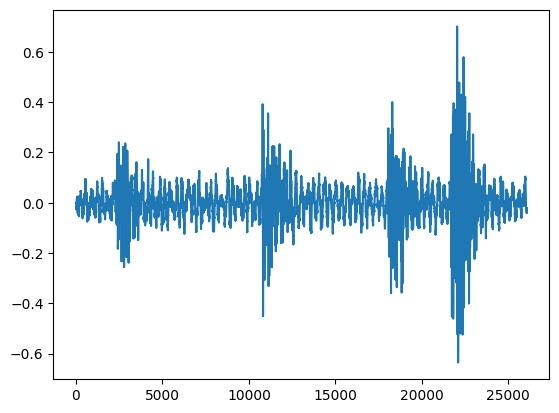

In [229]:
# Grab one of the audio files and plot the waveform.
testing_wav_file_name = os.path.join(data_positive_dir, '046.wav')
testing_wav_data = load_wav_16k_mono(testing_wav_file_name)
_ = plt.plot(testing_wav_data)
print(f"Shape of data is {testing_wav_data.shape}")
display.Audio(testing_wav_data, rate=16000)

In that case this waveform has 26067 samples (26067 / 16000 = 1.629 seconds).

That means that if we run inference on it we will get 3 sets of scores, since the model extracts frames 0.96 seconds long every 0.48 seconds (0-0.96, 0.48-1.44, 1.44-1.629).

## 2. Run Inference

See what does the model detect before doing any transference learning.

In [230]:
yamnet_model_handle = "https://tfhub.dev/google/yamnet/1"
yamnet_model = tfhub.load(yamnet_model_handle)

class_map_path = yamnet_model.class_map_path().numpy().decode("utf-8")
class_names = list(pd.read_csv(class_map_path)["display_name"])

class_names

['Speech',
 'Child speech, kid speaking',
 'Conversation',
 'Narration, monologue',
 'Babbling',
 'Speech synthesizer',
 'Shout',
 'Bellow',
 'Whoop',
 'Yell',
 'Children shouting',
 'Screaming',
 'Whispering',
 'Laughter',
 'Baby laughter',
 'Giggle',
 'Snicker',
 'Belly laugh',
 'Chuckle, chortle',
 'Crying, sobbing',
 'Baby cry, infant cry',
 'Whimper',
 'Wail, moan',
 'Sigh',
 'Singing',
 'Choir',
 'Yodeling',
 'Chant',
 'Mantra',
 'Child singing',
 'Synthetic singing',
 'Rapping',
 'Humming',
 'Groan',
 'Grunt',
 'Whistling',
 'Breathing',
 'Wheeze',
 'Snoring',
 'Gasp',
 'Pant',
 'Snort',
 'Cough',
 'Throat clearing',
 'Sneeze',
 'Sniff',
 'Run',
 'Shuffle',
 'Walk, footsteps',
 'Chewing, mastication',
 'Biting',
 'Gargling',
 'Stomach rumble',
 'Burping, eructation',
 'Hiccup',
 'Fart',
 'Hands',
 'Finger snapping',
 'Clapping',
 'Heart sounds, heartbeat',
 'Heart murmur',
 'Cheering',
 'Applause',
 'Chatter',
 'Crowd',
 'Hubbub, speech noise, speech babble',
 'Children playing'

In [231]:
scores, embeddings, spectogram = yamnet_model(testing_wav_data)

In [232]:
# Scores carry the 521 score results for each frame in the waveform. The wav data we
# used is 1.629 seconds long so we have 3 sets of scores (0-0.96, 0.48-1.44, 1.44-1.629)
# because each frame is 0.96 seconds long and the model extracts one frame every 0.48
# seconds.
print(f'Scores shape: {scores.shape}')
print(f'Embeddings shape: {embeddings.shape}')
print(f'Spectogram shape: {spectogram.shape}')

Scores shape: (3, 521)
Embeddings shape: (3, 1024)
Spectogram shape: (192, 64)


Since we have scores for 3 frames the best idea is to take top class across the various frames.

In [233]:
class_scores = tf.reduce_mean(scores, axis=0)
top_class = tf.argmax(class_scores)
infered_class = class_names[top_class]

print(f'The main sound is {infered_class}.')

The main sound is Inside, small room.


Sadly it detected _Inside, small room_ instead of a percussion sound, so we will retrain the network to give us accuracy on detecting the high heel percussion side.

## 3. Build Datasets

Build the train, test, and validation datasets.

In [234]:
pos_dir = os.path.join('dataset', 'positive')
neg_dir = os.path.join('dataset', 'negative')

pos = tf.data.Dataset.list_files(pos_dir + os.path.sep + '*.wav').map(load_wav_16k_mono)
neg = tf.data.Dataset.list_files(neg_dir + os.path.sep + '*.wav').map(load_wav_16k_mono)

positives = tf.data.Dataset.zip(
    (
        pos,
        tf.data.Dataset.from_tensor_slices(tf.ones(len(pos)))
    )
)

negatives = tf.data.Dataset.zip(
    (
        neg,
        tf.data.Dataset.from_tensor_slices(tf.zeros(len(neg)))
    )
)

main_ds = positives.concatenate(negatives).shuffle(1000)
main_ds_len = len(main_ds)
print(f"Prepared a dataset of length {main_ds_len}")

def extract_embedding(wav_data, label):
    scores, embeddings, spectogram = yamnet_model(wav_data)
    num_embeddings = tf.shape(embeddings)[0]
    return(
        embeddings,
        tf.repeat(label, num_embeddings)
    )

main_ds = main_ds.map(extract_embedding).unbatch()
print(f"Element spec: {main_ds.element_spec}")

cached_ds = main_ds.cache()

Prepared a dataset of length 113
Element spec: (TensorSpec(shape=(1024,), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.float32, name=None))


In [235]:
num_train = int(main_ds_len * 0.8)
num_test = int(main_ds_len * 0.1)
num_val = main_ds_len - num_train - num_test

print(f"Dataset sizes: train ({num_train}), test ({num_test}), val ({num_val})")

train_ds = main_ds.take(num_train)
test_ds = main_ds.skip(num_train).take(num_test)
val_ds = main_ds.skip(num_train + num_test).take(num_val)

train_ds = train_ds.cache().shuffle(1000).batch(16).prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.cache().batch(16).prefetch(tf.data.AUTOTUNE)
test_ds = test_ds.cache().batch(16).prefetch(tf.data.AUTOTUNE)

Dataset sizes: train (90), test (11), val (12)


## 4. Build Deep Learning Model

In [236]:
my_model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(1024), dtype=tf.float32, name='input_embedding'),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(200, activation='relu'),
    tf.keras.layers.Dense(1)
], name='my_model')

my_model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    optimizer='adam',
    metrics=['accuracy']
)

callback = tf.keras.callbacks.EarlyStopping(
    monitor='loss',
    patience=3,
    restore_best_weights=True
)

In [237]:
history = my_model.fit(
    train_ds,
    epochs=20,
    validation_data=val_ds,
    callbacks=callback
)

Epoch 1/20
6/6 [==============================] - 3s 308ms/step - loss: 0.6693 - accuracy: 0.6000 - val_loss: 0.3336 - val_accuracy: 0.9167
Epoch 2/20
6/6 [==============================] - 0s 10ms/step - loss: 0.4442 - accuracy: 0.7667 - val_loss: 0.3301 - val_accuracy: 0.9167
Epoch 3/20
6/6 [==============================] - 0s 9ms/step - loss: 0.3230 - accuracy: 0.8556 - val_loss: 0.2023 - val_accuracy: 0.9167
Epoch 4/20
6/6 [==============================] - 0s 10ms/step - loss: 0.2295 - accuracy: 0.9333 - val_loss: 0.1895 - val_accuracy: 0.9167
Epoch 5/20
6/6 [==============================] - 0s 11ms/step - loss: 0.1472 - accuracy: 0.9667 - val_loss: 0.2351 - val_accuracy: 0.9167
Epoch 6/20
6/6 [==============================] - 0s 11ms/step - loss: 0.1089 - accuracy: 0.9444 - val_loss: 0.2006 - val_accuracy: 0.9167
Epoch 7/20
6/6 [==============================] - 0s 12ms/step - loss: 0.0924 - accuracy: 0.9778 - val_loss: 0.1905 - val_accuracy: 0.9167
Epoch 8/20
6/6 [===========

In [238]:
loss, accuracy = my_model.evaluate(test_ds)
print(f"Loss: {loss}")
print(f"Accuracy: {accuracy}")

1/1 [==============================] - 1s 1s/step - loss: 1.0860 - accuracy: 0.9091
Loss: 1.0860238075256348
Accuracy: 0.9090909361839294


## 4. Test the Model

Try an individual sample to see if it detects it as high-heel or not.

In [239]:
positive_wav = load_wav_16k_mono(
    os.path.join("dataset", "positive", "005.wav")
)

scores, embeddings, spectrogram = yamnet_model(positive_wav)
high_heels_score = my_model(embeddings).numpy().max()
print(f"High heels score: {high_heels_score}")
print(f"Is it a high heel? {high_heels_score > 0}")

display.Audio(positive_wav, rate=16000)

High heels score: 7.477571487426758
Is it a high heel? True


In [240]:
negative_sample = load_wav_16k_mono(
    os.path.join("dataset", "negative", "007.wav")
)

scores, embeddings, spectrogram = yamnet_model(negative_sample)
high_heels_score = my_model(embeddings).numpy().max()
print(f"High heels score: {high_heels_score}")
print(f"Is it a high heel? {high_heels_score > 0}")

display.Audio(negative_sample, rate=16000)


High heels score: -9.491233825683594
Is it a high heel? False
